# 2.2 DL Studio
### Run CIFAR-10 Example
For Net, the overall accuracy of the network on the 10000 test images: 53 %
For Net2, the overall accuracy of the network on the 10000 test images: 67 %

Net2 outperforms Net, the primary reason for this improvement is that Net2 has an additional convolutional layer and features more channels in each layer, enhancing its ability to learn more complex patterns.

### Analyze Resolution Changes
CIFAR-10 images are typically of size 32x32 pixels and have 3 color channels (RGB), which is (batch_size, 3, 32, 32).

Let's use Net for analyzing resolution:
```self.conv1 = nn.Conv2d(3, 6, 5) (input channel, output channel, kernel size)```
Output -> The kernel size is 5x5 with a stride of 1 (default), so the spatial dimensions (height and width) of the image are reduced by 4 pixels. Hence, the output will be (batch_size, 6, 28, 28) (32-5+1)
```x = nn.MaxPool2d(2, 2)(F.relu(self.conv1(x)))```
Max pooling with a 2x2 kernel halves the spatial resolution. Output will be (batch_size, 6, 14, 14)
```self.conv2 = nn.Conv2d(6, 16, 5)```
Output: (batch_size, 16, 10, 10)
```x = nn.MaxPool2d(2, 2)(F.relu(self.conv2(x)))```
Output: (batch_size, 16, 5, 5)
```x = x.view(x.shape[0], -1)```
Output: (batch_size, 16*5*5 = 400)

And FC layers, which is easy, for example, fc1:
```self.fc1 = nn.Linear(16 * 5 * 5, 120)```
Output: (batch_size, 120)

### Consider Kernel Sizes and Padding
For Net, using a 5x5 kernel in Net is relatively large. A larger kernel can be beneficial for reducing the number of layers and capturing bigger features. However, it also results in more parameters, which increases the risk of overfitting. Typically, architectures like VGG and ResNet use 3x3 kernels, which are more efficient for deeper neural networks. We can also use a hybrid approach by combining different kernel sizes to capture multi-scale information.

# 3.2 Dataset Creation Instructions
To create a personal dataset by extracting a subset of the COCO dataset, we can utilize the provided code in the manual. However, to store the images separately for the training and validation sets, we introduce an additional list, images_to_process, which will temporarily store the image metadata.

Instead of saving the images directly in the for loop, we append the image metadata to this list. Afterward, we can split the images_to_process list into two separate lists—one for the training images and the other for validation images. Finally, we use two separate for loops to save the images accordingly into their respective directories.

In [ ]:
# this code is borrow from HW4_spring2025.pdf, my code will be follow by a comment
from PIL import Image
import os
from pycocotools.coco import COCO

# Set COCO dataset paths
data_dir = os.getcwd()
ann_file = os.path.join(data_dir, "annotations/instances_train2014.json") 
image_dir = os.path.join(data_dir, "train2014/train2014")  
output_dir = "output_datasets"

# Load COCO dataset
coco = COCO(ann_file)

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def save_image(img_info, category_name, dataset_type, split):
    """Saves the extracted image into a structured output directory for training/validation."""
    img_path = os.path.join(image_dir, img_info['file_name'])
    save_dir = os.path.join(output_dir, dataset_type, split, category_name)
    os.makedirs(save_dir, exist_ok=True)

    # Load and resize image
    img = Image.open(img_path).resize((64, 64))
    img.save(os.path.join(save_dir, img_info['file_name']))

def extract_images(cat_names, min_instances=1, max_instances=1, multiple_categories=False, dataset_type="single_instance"):
    """
    Extracts images based on object count conditions for single-instance or multi-instance datasets.
    - min_instances: Minimum number of object instances required.
    - max_instances: Maximum number of object instances allowed.
    - multiple_categories: If True, selects images with multiple different object types.
    """
    cat_ids = coco.getCatIds(catNms=cat_names)
    img_ids = coco.getImgIds(catIds=cat_ids)
    # Counter for extracted images
    extracted = 0  

    
    images_to_process = [] # List to store valid images
    target_classes = ["person", "car", "bottle", "cup", "chair"] # remeber classes we are interested in, with single categories, we need to make sure that other categories are not present
    current_category = cat_names[0] ## e.g. current_category: person
    other_categories = [cat for cat in target_classes if cat != current_category] ## e.g. other_categories: ['book', 'bottle', 'cup', 'chair']


    # loop through the images
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        # These are annotation IDs for objects detected in a specific image. (we are not using this)
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        # anns includes bounding box, category ID, and segmentation, area, imageID.
        anns = coco.loadAnns(ann_ids)


        # Count objects per category
        obj_counts = {}

        obj_categories = set() # set to store object categories in the image. e.g. {'person', 'chair'}
        
        # max_area_category = None # variable to store the category with the maximum area
        # max_area = 0

        for ann in anns:
            # return object category name, like obj_category: umbrella, obj_category: carrot...
            obj_category = coco.loadCats(ann['category_id'])[0]['name']

            # obj count for each category, like obj_counts: {'umbrella': 1}, obj_counts: {'carrot': 3}...
            obj_counts[obj_category] = obj_counts.get(obj_category, 0) + 1
            
            obj_categories.add(obj_category) # keep track of all object categories in the image

        #     if ann['area'] > max_area: # Track category with largest area
        #         max_area = ann['area']
        #         max_area_category = obj_category

        # if max_area_category != current_category: # Skip images with largest area not being the target category
        #     continue
        
        if dataset_type in ["single_instance", "multi_instance_same"]: # Skip images with other unwanted categories for single-instance and multi-instance same"
            if any(other_cat in obj_categories for other_cat in other_categories):
                continue

        if multiple_categories:
            # Ensure multiple object categories are present(modified)
            if len(obj_counts) >= 2 and current_category in obj_counts and any(other_cat in obj_counts for other_cat in other_categories): # modified this line to include other_categories
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        elif dataset_type == "multi_instance_same":
            # Ensure multiple instances of the same object category
            if cat_names[0] in obj_counts and obj_counts[cat_names[0]] >= min_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        else:
            # Ensure the number of instances falls within the desired range for single-instance
            if all(obj in obj_counts for obj in cat_names) and min_instances <= obj_counts[cat_names[0]] <= max_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1

        # Limit to 500 images per dataset for testing 
        if extracted >= 500:  
            break
        
    train_images = images_to_process[:400] # Split the images into training and validation sets (400 training, 100 validation)
    val_images = images_to_process[400:500] # Split the images into training and validation sets (400 training, 100 validation)

    for img_info in train_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'train')

    for img_info in val_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'val')


loading annotations into memory...
Done (t=12.13s)
creating index...
index created!


### 1. 5x3 Images


To visualize the datasets, I used Matplotlib to display a 5x3 grid of randomly selected images for each dataset variation. By iterating through the target classes and dataset types, the script retrieves images from the structured dataset directories, ensuring that three images per class are displayed when available.

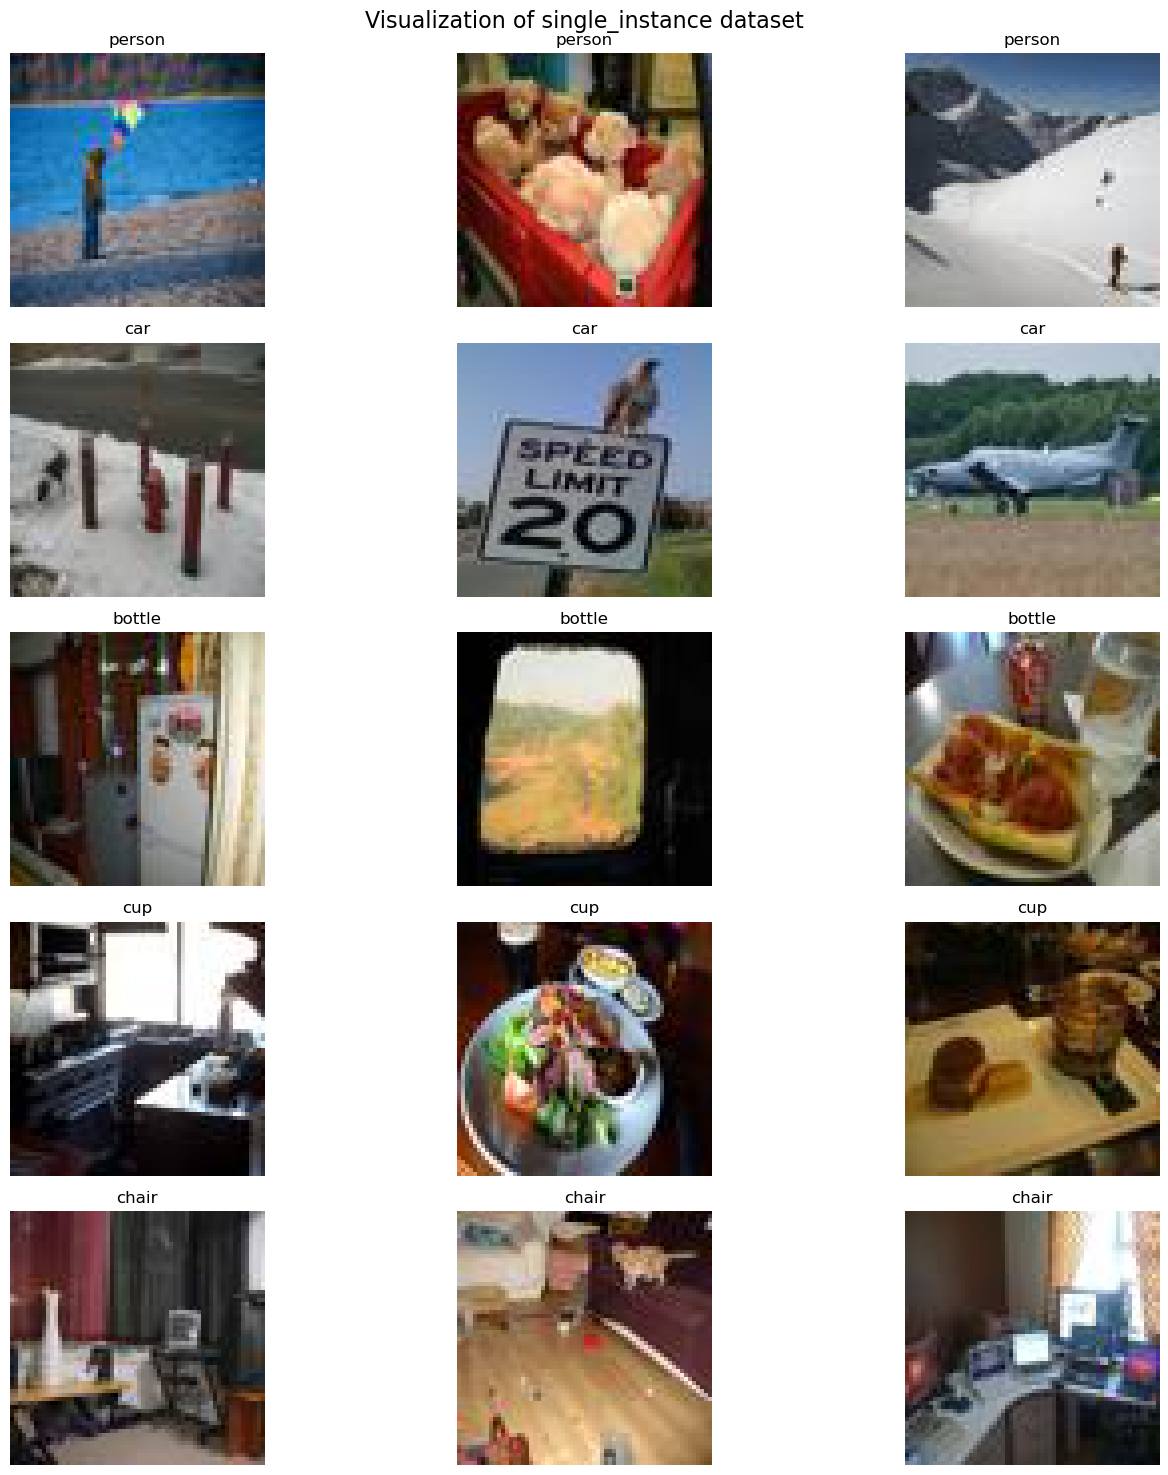

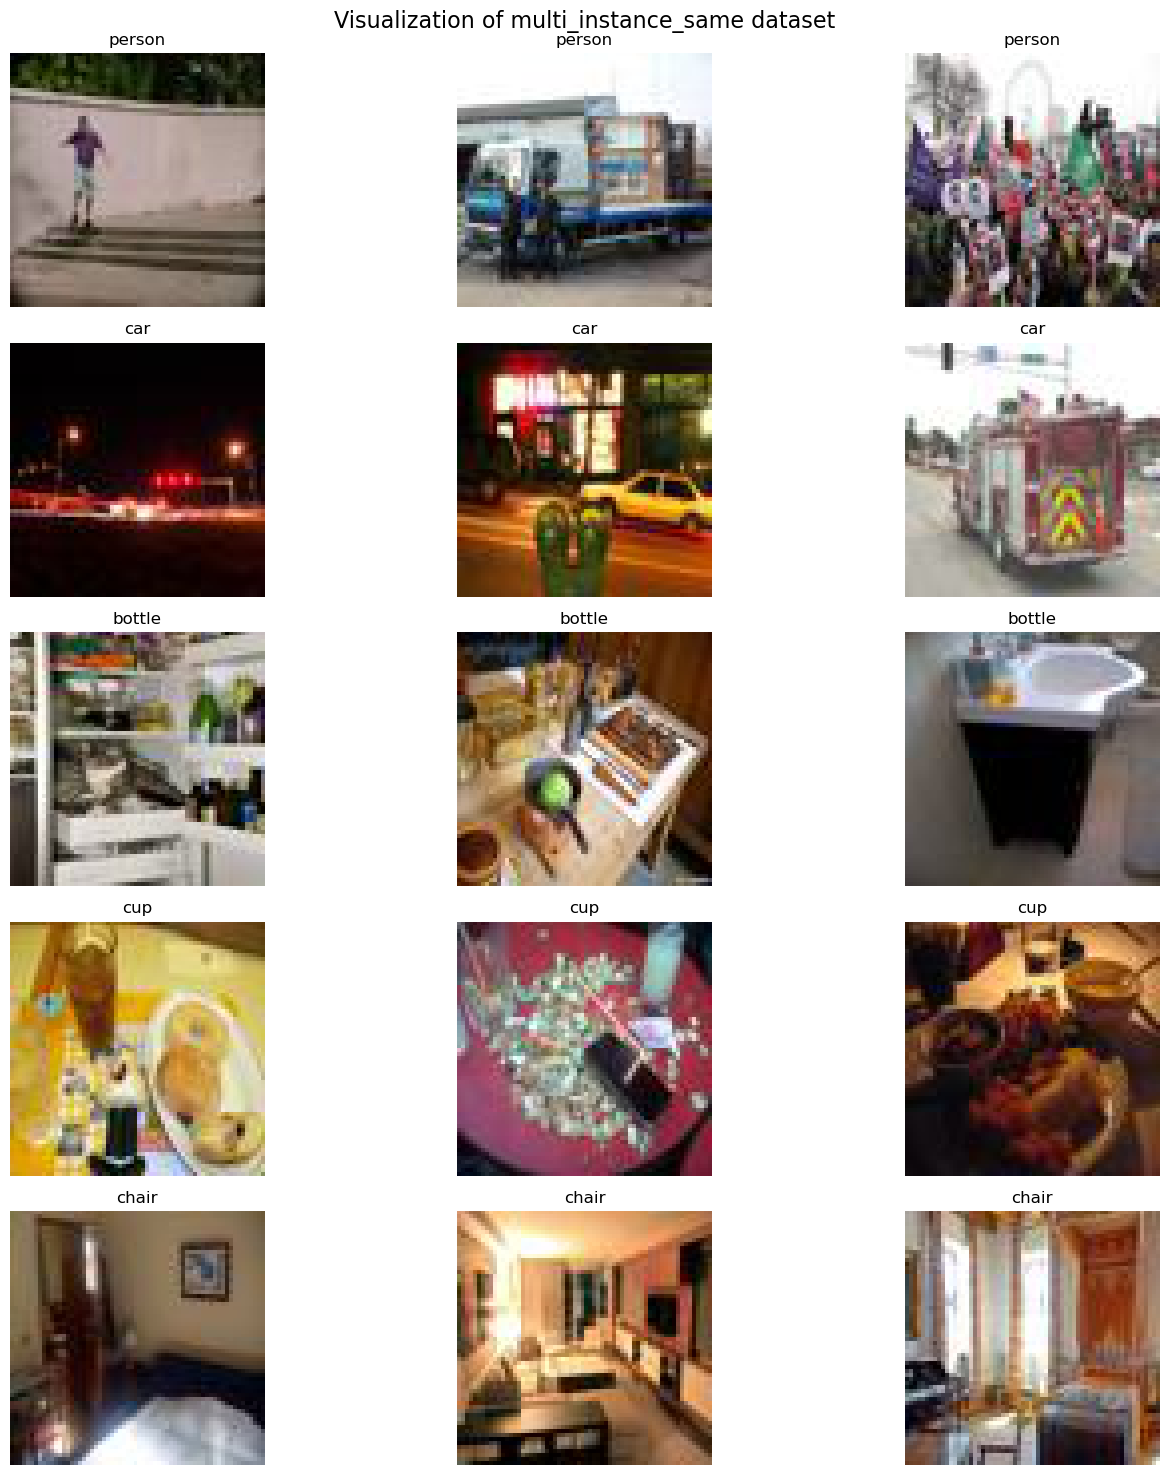

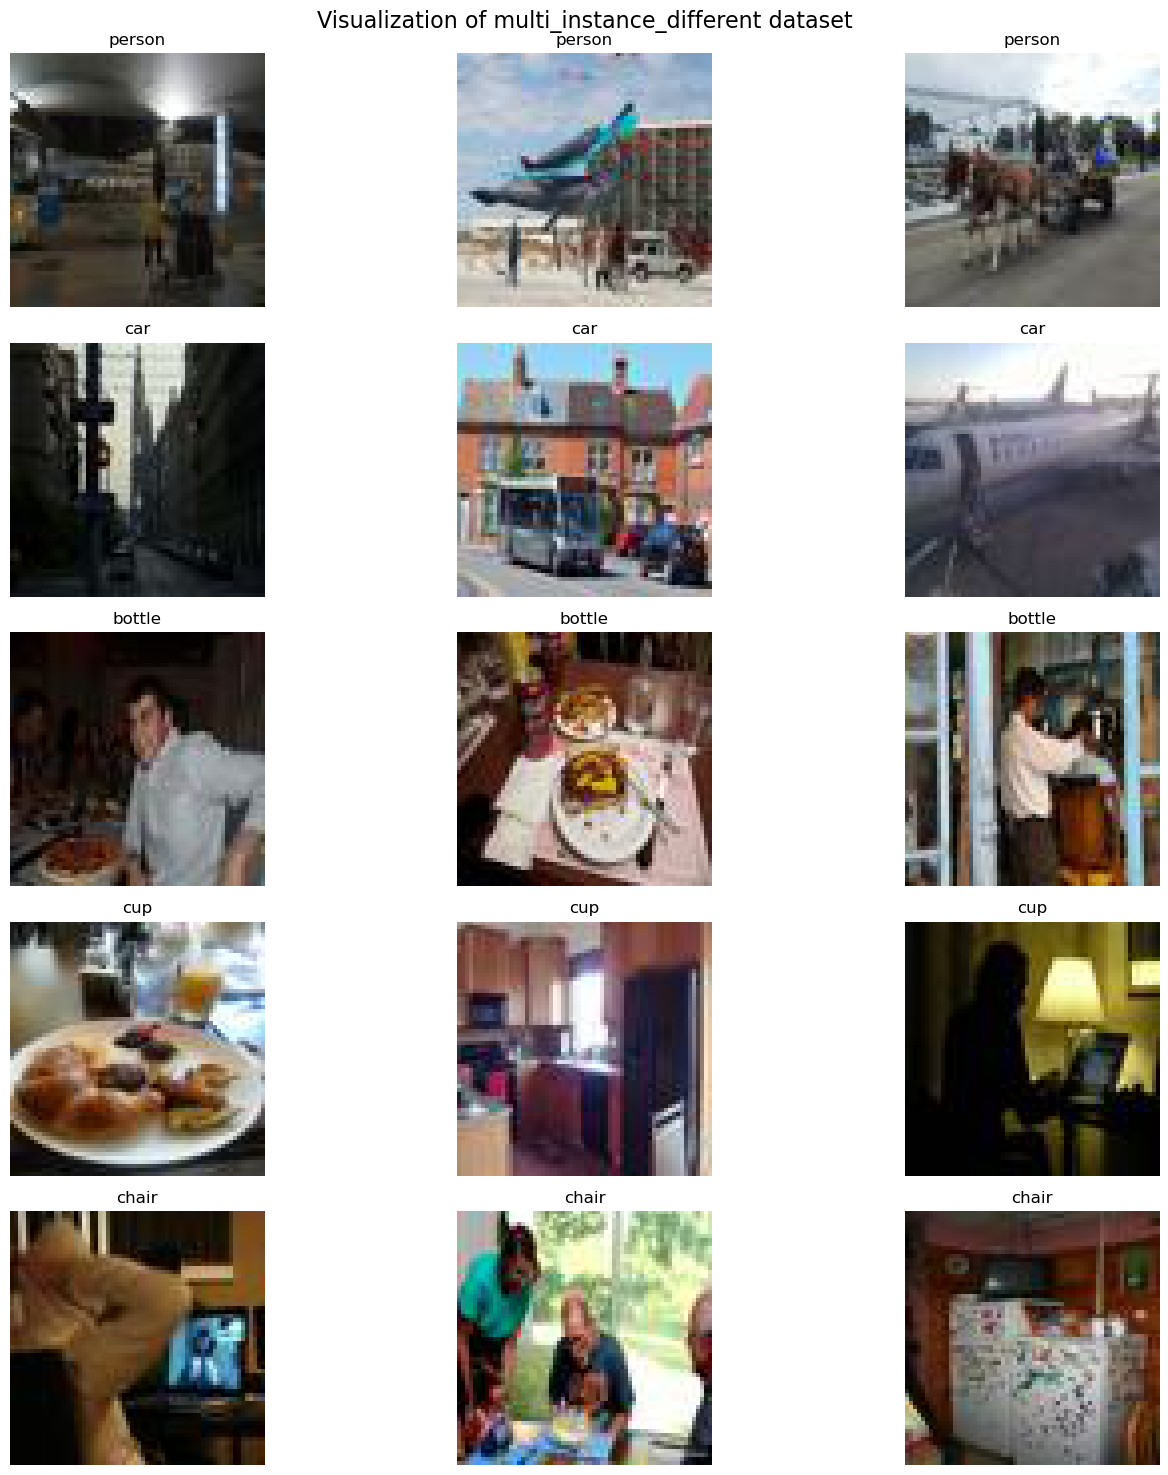

In [22]:
import matplotlib.pyplot as plt
import random

def visualize_dataset(dataset_type, classes, output_dir="output_datasets"):
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))  # 5 rows x 3 columns grid
    fig.suptitle(f"Visualization of {dataset_type} dataset", fontsize=16)
    
    image_paths = []
    
    for category in classes:
        category_path = os.path.join(output_dir, dataset_type, 'train', category)
        if os.path.exists(category_path) and os.listdir(category_path):
            category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)] 
            random.shuffle(category_images)
            image_paths.extend(category_images[:3]) # Select 3 images per class
    
    image_paths = image_paths[:15]  # Ensure only 15 images for the grid
    
    for ax, img_path in zip(axes.ravel(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(os.path.dirname(img_path)))  # Display category name
    
    plt.tight_layout()
    plt.show()

target_classes = ["person", "car", "bottle", "cup", "chair"]
dataset_variations = ["single_instance", "multi_instance_same", "multi_instance_different"]

for variation in dataset_variations:
    visualize_dataset(variation, target_classes)

### 2. 3x5 Tables
By using count_images_in_directory, I can get the image of each class and data type

In [ ]:
def count_images_in_directory(directory):
    image_extensions = {'.jpg', '.jpeg', '.png'}
    total_images = 0

    for root, _, files in os.walk(directory):
        image_count = sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)
        if image_count > 0:
            print(f"{root}: {image_count} images")
        total_images += image_count

    print(f"\nTotal images: {total_images}")

count_images_in_directory("output_datasets")


Total images: 0



##### Train
| Dataset Type          | Person | Car  | Bottle | Cup  | Chair |
|----------------------|--------|------|--------|------|--------|
| Single Instance     | 400      | 400    | 400      | 400    | 400      |
| Multi Instance Same | 400      | 400    | 400      | 400    | 400      |
| Multi Instance Diff | 400      | 400    | 400      | 400    | 400      |

##### Validation
| Dataset Type          | Person | Car  | Bottle | Cup  | Chair |
|----------------------|--------|------|--------|------|--------|
| Single Instance     | 100      | 100    | 100      | 100    | 100      |
| Multi Instance Same | 100      | 100    | 100      | 100    | 100      |
| Multi Instance Diff | 100      | 100    | 100      | 100    | 100      |

Total Images: 7500

# 3.3 Image Classification using CNNs– Training and Validation


### CNN for Dataset 1

##### Train loss plot

I identify the number of parameters in the comment

Class Index Mapping: {'bottle': 0, 'car': 1, 'chair': 2, 'cup': 3, 'person': 4}
Conv2d: torch.Size([1, 16, 62, 62])
ReLU: torch.Size([1, 16, 62, 62])
MaxPool2d: torch.Size([1, 16, 31, 31])
Conv2d: torch.Size([1, 32, 29, 29])
ReLU: torch.Size([1, 32, 29, 29])
MaxPool2d: torch.Size([1, 32, 14, 14])
Flatten: torch.Size([1, 6272])
Linear: torch.Size([1, 64])
ReLU: torch.Size([1, 64])
Linear: torch.Size([1, 5])
Training on device: cuda
[epoch: 1, batch:    10] loss: 0.159
[epoch: 1, batch:    20] loss: 0.151
[epoch: 1, batch:    30] loss: 0.149
Accuracy of validation: 35.2%
[epoch: 2, batch:    10] loss: 0.146
[epoch: 2, batch:    20] loss: 0.141
[epoch: 2, batch:    30] loss: 0.147
Accuracy of validation: 36.6%
[epoch: 3, batch:    10] loss: 0.146
[epoch: 3, batch:    20] loss: 0.141
[epoch: 3, batch:    30] loss: 0.143
Accuracy of validation: 40.8%
[epoch: 4, batch:    10] loss: 0.140
[epoch: 4, batch:    20] loss: 0.133
[epoch: 4, batch:    30] loss: 0.138
Accuracy of validation: 39.8%
[

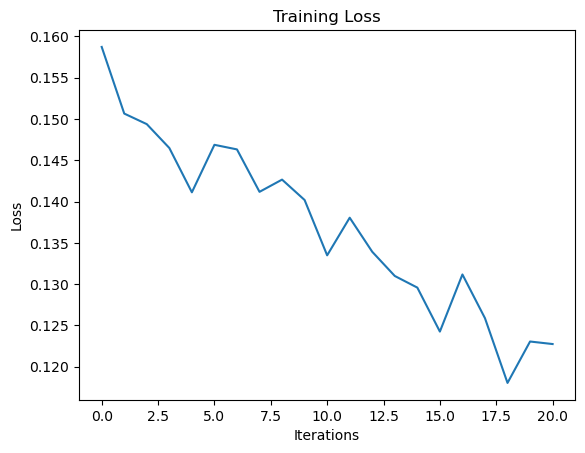

In [24]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

transform = transforms.Compose([
    transforms.ToTensor(),    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomRotation(degrees=5),     
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
])

which_dataset = "single_instance"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Class Index Mapping: {train_dataset.class_to_idx}") ## Class Index Mapping: {'bottle': 0, 'car': 1, 'chair': 2, 'cup': 3, 'person': 4}

# this is the same as pdf, but in sequential. Input size is 64x64x3, output size is 5
HW4Net = nn.Sequential(
    nn.Conv2d(3, 16, 3), # default stride is 1, padding is 0. Formula: ((W - K + 2P)/S) + 1, ((64 - 3 + 0)/1) + 1 = 62. Output: (16, 62, 62)
    nn.ReLU(), 
    nn.MaxPool2d(2, 2), # Formula:  ((H - K) / S) + 1. Halves both dimensions since kernel=2 and stride=2. 
                        # Output: (16, 31, 31)

    nn.Conv2d(16, 32, 3), # Formula: ((W - K + 2P)/S) + 1, ((31 - 3 + 0)/1) + 1 = 29. Output: (32, 29, 29)
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Halves both dimensions since kernel=2 and stride=2. Output: (32, 14, 14)

    nn.Flatten(), # 32*14*14 = 6272. Output: (6272,)
    nn.Linear(6272, 64), # Output: (64,)
    nn.ReLU(),
    nn.Linear(64, 5) # 5 output classes
)

# Create a dummy input tensor
x = torch.randn(1, 3, 64, 64)  # Batch size = 1, 3 channels, 64x64 image

for layer in HW4Net:
    x = layer(x)
    print(f"{layer.__class__.__name__}: {x.shape}")

def train_model(model, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    model = model.to(device) # change model here 

    # these code is borrowed from pdf, the one I created will be followed by a comment
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
    epochs = 7

    track_loss = []
    for epoch in range(epochs):
        model.train()  # Switch to training mode
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # reset the gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i+1) % 10 == 0:
                print("[epoch: %d, batch: %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
                track_loss.append(running_loss / 100)
                running_loss = 0.0

        # Validation
        model.eval()  # Switch to evaluation mode
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        missclassified = []

        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1) # get the class index with the highest probability. output.data is the output tensor, 1 is the dimension to reduce
                correct += (predicted == labels).sum().item()# sum up the number of correct predictions. .item() is used to get the value of the tensor
                total += labels.size(0)
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                # add misclassified image into the list
                for j in range(len(labels)):
                    if predicted[j] != labels[j]:  # If the prediction is wrong
                        missclassified.append((images[j].cpu(), labels[j].cpu().item(), predicted[j].cpu().item()))

        print(f"Accuracy of validation: {100 * correct / total}%")


    plt.plot(track_loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


    return true_labels, predicted_labels, missclassified

true_labels, predicted_labels, missclassified = train_model(HW4Net, train_loader, val_loader)



##### Confusion Matrix plot

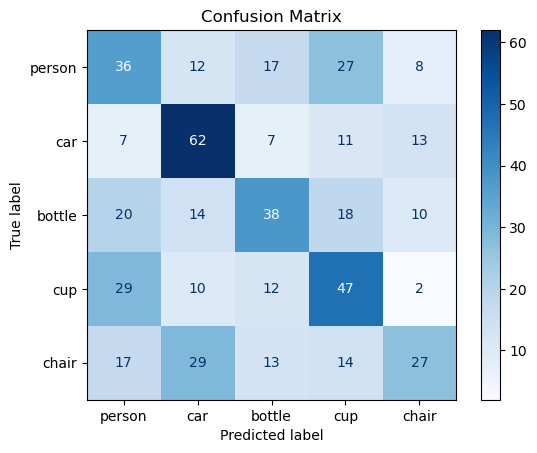

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### CNN for Dataset 2

##### Train loss plot

Training on device: cuda
[epoch: 1, batch:    10] loss: 0.141
[epoch: 1, batch:    20] loss: 0.137
[epoch: 1, batch:    30] loss: 0.133
Accuracy of validation: 41.8%
[epoch: 2, batch:    10] loss: 0.126
[epoch: 2, batch:    20] loss: 0.127
[epoch: 2, batch:    30] loss: 0.129
Accuracy of validation: 43.4%
[epoch: 3, batch:    10] loss: 0.124
[epoch: 3, batch:    20] loss: 0.125
[epoch: 3, batch:    30] loss: 0.124
Accuracy of validation: 44.0%
[epoch: 4, batch:    10] loss: 0.117
[epoch: 4, batch:    20] loss: 0.121
[epoch: 4, batch:    30] loss: 0.120
Accuracy of validation: 46.8%
[epoch: 5, batch:    10] loss: 0.113
[epoch: 5, batch:    20] loss: 0.114
[epoch: 5, batch:    30] loss: 0.112
Accuracy of validation: 46.2%
[epoch: 6, batch:    10] loss: 0.101
[epoch: 6, batch:    20] loss: 0.108
[epoch: 6, batch:    30] loss: 0.112
Accuracy of validation: 45.0%
[epoch: 7, batch:    10] loss: 0.105
[epoch: 7, batch:    20] loss: 0.104
[epoch: 7, batch:    30] loss: 0.103
Accuracy of valida

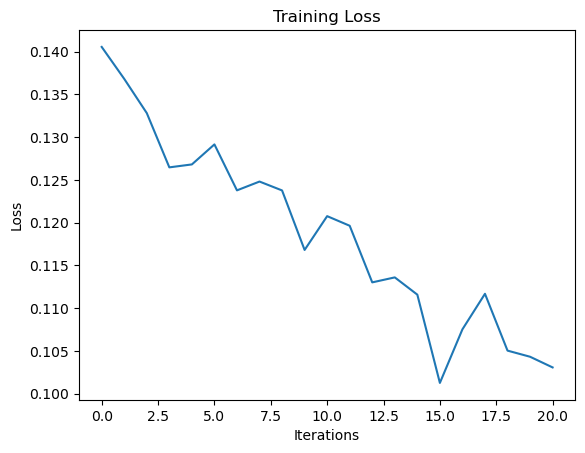

In [26]:
torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

which_dataset = "multi_instance_same"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


true_labels, predicted_labels, missclassified = train_model(HW4Net, train_loader, val_loader)


##### Confusion Matrix plot

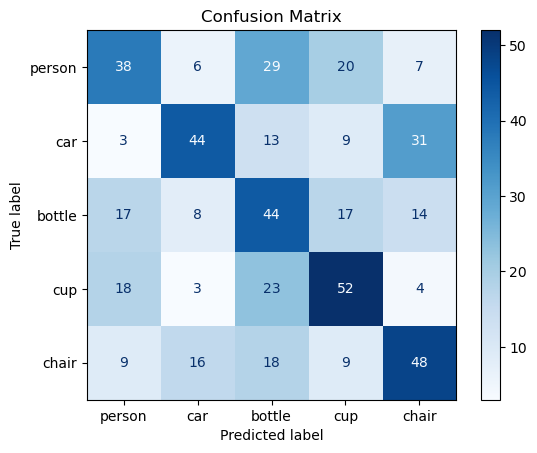

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### CNN for Dataset 3

##### Train loss plot

Training on device: cuda
[epoch: 1, batch:    10] loss: 0.161
[epoch: 1, batch:    20] loss: 0.151
[epoch: 1, batch:    30] loss: 0.150
Accuracy of validation: 28.2%
[epoch: 2, batch:    10] loss: 0.144
[epoch: 2, batch:    20] loss: 0.148
[epoch: 2, batch:    30] loss: 0.147
Accuracy of validation: 29.4%
[epoch: 3, batch:    10] loss: 0.143
[epoch: 3, batch:    20] loss: 0.146
[epoch: 3, batch:    30] loss: 0.144
Accuracy of validation: 28.2%
[epoch: 4, batch:    10] loss: 0.140
[epoch: 4, batch:    20] loss: 0.145
[epoch: 4, batch:    30] loss: 0.139
Accuracy of validation: 31.6%
[epoch: 5, batch:    10] loss: 0.137
[epoch: 5, batch:    20] loss: 0.140
[epoch: 5, batch:    30] loss: 0.138
Accuracy of validation: 26.4%
[epoch: 6, batch:    10] loss: 0.135
[epoch: 6, batch:    20] loss: 0.134
[epoch: 6, batch:    30] loss: 0.137
Accuracy of validation: 30.2%
[epoch: 7, batch:    10] loss: 0.134
[epoch: 7, batch:    20] loss: 0.133
[epoch: 7, batch:    30] loss: 0.134
Accuracy of valida

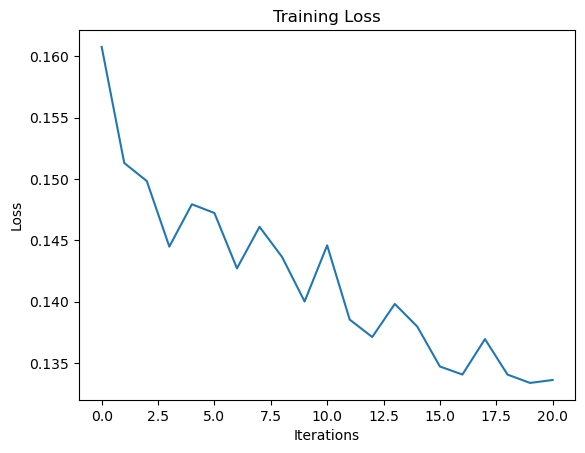

In [28]:
torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

which_dataset = "multi_instance_different"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


true_labels, predicted_labels, missclassified = train_model(HW4Net, train_loader, val_loader)

##### Confusion Matrix plot

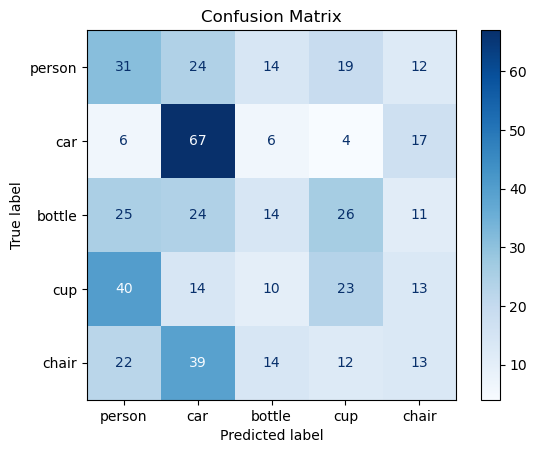

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Table of Accuracies
| Dataset Type          |  HW4Net | 
|----------------------|--------|
| Single Instance     | 42%      | 
| Multi Instance Same | 45.2%      | 
| Multi Instance Diff | 29.6%      | 

### Observations from Conf matrix and table of accuracies
##### 1. By observing your classification accuracies, which dataset think are more difficult to correctly differentiate and why 

The classification accuracy is lower for the multi-instance-different dataset compared to the single-instance dataset. This happens because the presence of multiple instances from different classes in the image creates confusion for the model. The model has to learn how to distinguish between multiple objects with varying scales and orientations, making the task significantly more complex. The model’s attention is split between several classes, and the object recognition becomes harder, which leads to lower accuracy. 

##### 2. By observing your confusion matrices, which class or classes do you think are more difficult to correctly differentiate and why?

It might seem counterintuitive that the "person" class performs the worst in the single-instance and multi-instance same dataset, especially since people generally cover a large portion of the image and are visually distinctive. One possible reason could be background variability. In real-world images, people are often surrounded by complex, varied backgrounds, which can confuse the model. The model might struggle to separate the person from the background, particularly in cases where the background is visually similar to other classes.

Chair performs the worst in multi-instance same and multi-instance different datasets. Chair often is relatively small, especially in a cluttered scene, and might appear in a less distinctive context. In multi-instance scenarios, where the image has several objects, the model might be distracted by other, larger or more visually distinct objects that dominate the image. The Chair's smaller size or similarity to other objects in the scene can make it difficult for the model to correctly identify it.


##### 3. What is one thing that you propose to make the classification performance better

One way to improve the performance is by using a deeper convolutional neural network. A deeper network allows for more complex feature extraction, which can help the model better understand intricate patterns in the data, especially in cases of multi-instance images with varying scales and orientations. Deeper layers can capture more abstract representations of objects, leading to better generalization and improved performance.

Techniques such as residual networks (ResNets) or other advanced architectures like DenseNets or Inception Networks might be useful to improve the depth and efficiency of the model.

Hyperparameters like learning rate, batch size, number of epochs, optimizer choice, and the architecture itself can also have a significant impact on model performance. Hyperparameter tuning through methods like grid search or random search can help find the optimal combination for your problem. For example, adjusting the learning rate to prevent the model from overshooting the minimum during training or tweaking the number of layers can yield better results.

### Plot misclassified images

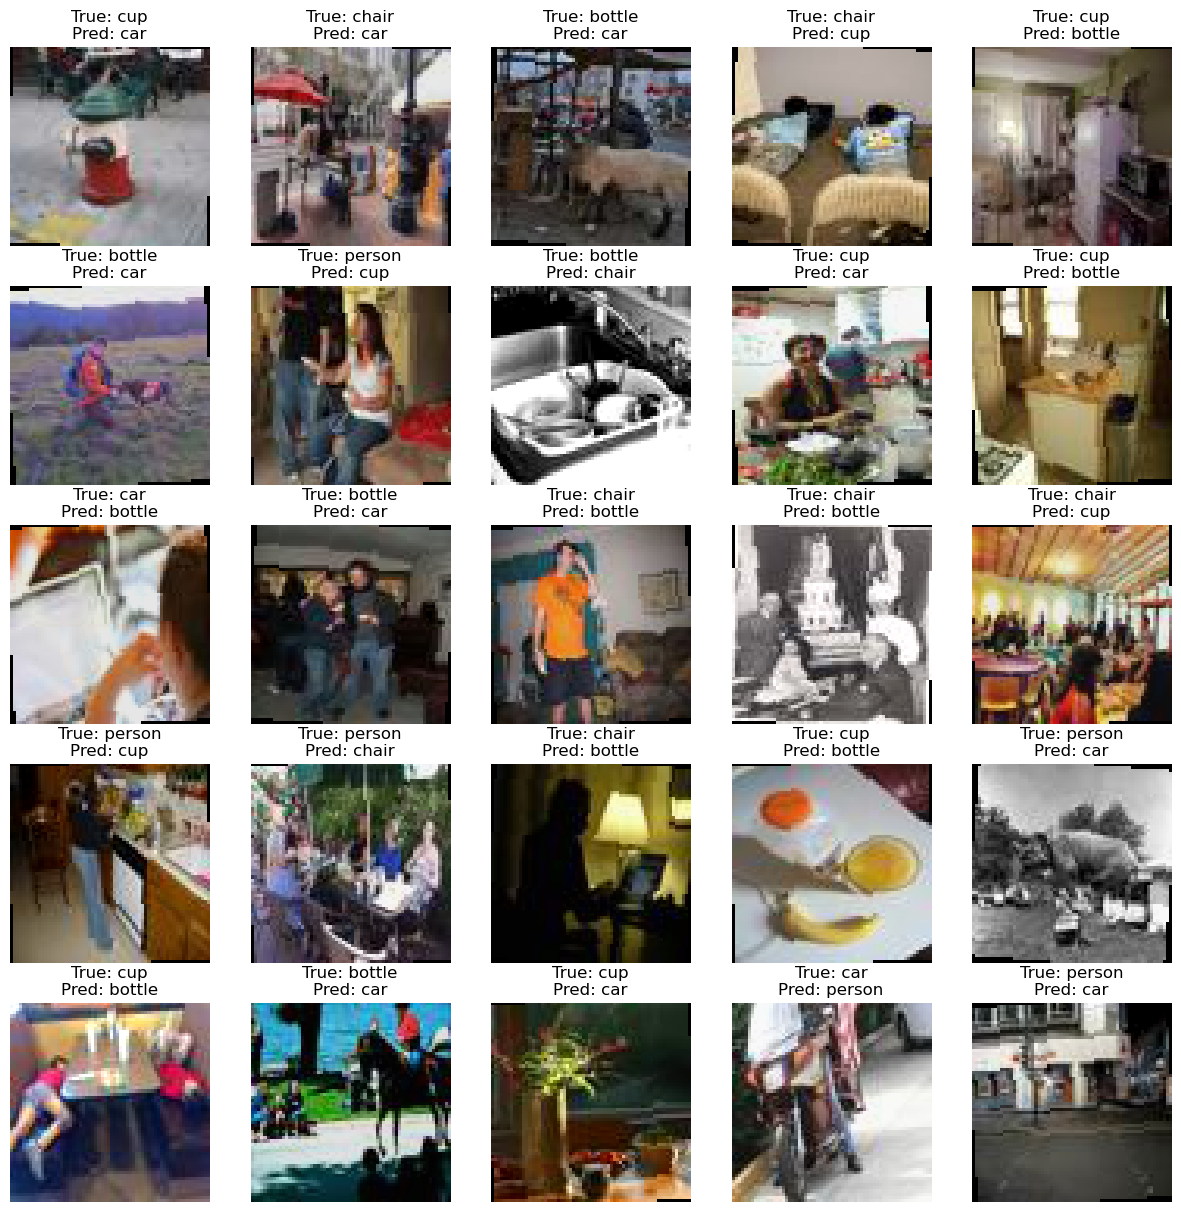

In [30]:
import random
def plot_misclassified(misclassified, class_names):
  
    random.shuffle(misclassified)

    num_images = 25

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()  # Flatten axes array to easily iterate over

    for i in range(num_images):
        img, true_label, pred_label = misclassified[i]
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

        # Denormalize if using normalization in transform
        img = (img * 0.5) + 0.5  

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        axes[i].axis("off")
    plt.show()

# Plot misclassified images
random.shuffle(missclassified)
missclassified = missclassified[:25]

plot_misclassified(missclassified, class_names=train_dataset.classes)


# Bonus

### Tain/confmatrices



In [60]:
HWNet1 = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(3, 32, 3, padding=1), # Formula: ((W - K + 2P)/S) + 1. ((64 - 3 + 2)/1) + 1 = 64. Output: (32, 64, 64)
    nn.BatchNorm2d(32), 
    nn.ReLU(),
    # Second convolutional layer
    nn.Conv2d(32, 32, 3, padding=1), # Output: (32, 64, 64)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Formula:  ((H - K) / S) + 1. Halves both dimensions since kernel=2 and stride=2. Output: (32, 32, 32)
    nn.Dropout2d(0.05), 

    # Third convolutional layer
    nn.Conv2d(32, 64, 3, padding=1), # (32  -3 + 1)/1 + 1 = 32. Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    # Fourth convolutional layer
    nn.Conv2d(64, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Output: (64, 16, 16)
    nn.Dropout2d(0.05),

    # Fifth convolutional layer
    nn.Conv2d(64, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Output: (128, 8, 8)
    nn.Dropout2d(0.05),

    # Fully connected layers
    nn.Flatten(), # Output: (128*8*8 = 8192, )
    nn.Linear(8192, 512), # Output: (512, )
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(512, 128), # Output: (128, )
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(128, 5) # Output: 5 classes
)




HWNet2 = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(3, 32, 3, padding=1), # Formula: ((W - K + 2P)/S) + 1. ((64 - 3 + 2)/1) + 1 = 64. Output: (32, 64, 64)
    nn.BatchNorm2d(32), 
    nn.ReLU(),

    # Second convolutional layer
    nn.Conv2d(32, 32, 3, padding=1), # Output: (32, 64, 64)
    nn.BatchNorm2d(32),
    nn.ReLU(),

    # Third convolutional layer
    nn.Conv2d(32, 32, 3, padding=1), # (64  -3 + 1)/1 + 1 = 32. Output: (32, 64, 64)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Output: (32, 32, 32) 

    # Fourth convolutional layer
    nn.Conv2d(32, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # Fifth convolutional layer
    nn.Conv2d(64, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # Sixth convolutional layer
    nn.Conv2d(64, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(), 
    nn.MaxPool2d(2, 2), # Output: (64, 16, 16)

    # Seventh convolutional layer
    nn.Conv2d(64, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Eigth convolutional layer
    nn.Conv2d(128, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Ninth convolutional layer
    nn.Conv2d(128, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(), 
    nn.MaxPool2d(2, 2), # Output: (128, 8, 8)

    # tenth convolutional layer
    nn.Conv2d(128, 128, 3, padding=1), # Output: (128, 8, 8)
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Fully connected layers
    nn.Flatten(), # Output: (128*8*8 = 8192, )
    nn.Linear(8192, 512), # Output: (512, )
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.05),

    nn.Linear(512, 128), # Output: (128, )
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.05),

    nn.Linear(128, 5) # Output: 5 classes
)

Training on device: cuda
[epoch: 1, batch:    10] loss: 0.159
[epoch: 1, batch:    20] loss: 0.151
[epoch: 1, batch:    30] loss: 0.145
Accuracy of validation: 37.0%
[epoch: 2, batch:    10] loss: 0.136
[epoch: 2, batch:    20] loss: 0.141
[epoch: 2, batch:    30] loss: 0.140
Accuracy of validation: 41.2%
[epoch: 3, batch:    10] loss: 0.132
[epoch: 3, batch:    20] loss: 0.132
[epoch: 3, batch:    30] loss: 0.135
Accuracy of validation: 42.4%
[epoch: 4, batch:    10] loss: 0.128
[epoch: 4, batch:    20] loss: 0.130
[epoch: 4, batch:    30] loss: 0.129
Accuracy of validation: 42.0%
[epoch: 5, batch:    10] loss: 0.121
[epoch: 5, batch:    20] loss: 0.127
[epoch: 5, batch:    30] loss: 0.124
Accuracy of validation: 43.4%
[epoch: 6, batch:    10] loss: 0.114
[epoch: 6, batch:    20] loss: 0.114
[epoch: 6, batch:    30] loss: 0.125
Accuracy of validation: 42.6%
[epoch: 7, batch:    10] loss: 0.108
[epoch: 7, batch:    20] loss: 0.113
[epoch: 7, batch:    30] loss: 0.116
Accuracy of valida

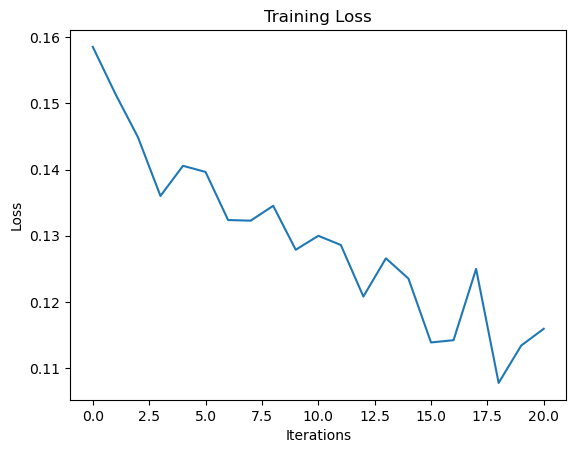

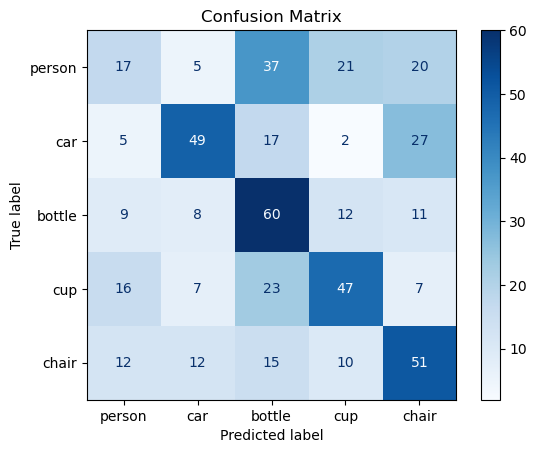

Training on device: cuda
[epoch: 1, batch:    10] loss: 0.160
[epoch: 1, batch:    20] loss: 0.149
[epoch: 1, batch:    30] loss: 0.154
Accuracy of validation: 25.4%
[epoch: 2, batch:    10] loss: 0.149
[epoch: 2, batch:    20] loss: 0.140
[epoch: 2, batch:    30] loss: 0.145
Accuracy of validation: 33.0%
[epoch: 3, batch:    10] loss: 0.139
[epoch: 3, batch:    20] loss: 0.142
[epoch: 3, batch:    30] loss: 0.142
Accuracy of validation: 32.4%
[epoch: 4, batch:    10] loss: 0.141
[epoch: 4, batch:    20] loss: 0.142
[epoch: 4, batch:    30] loss: 0.138
Accuracy of validation: 37.8%
[epoch: 5, batch:    10] loss: 0.136
[epoch: 5, batch:    20] loss: 0.135
[epoch: 5, batch:    30] loss: 0.134
Accuracy of validation: 40.8%
[epoch: 6, batch:    10] loss: 0.132
[epoch: 6, batch:    20] loss: 0.128
[epoch: 6, batch:    30] loss: 0.136
Accuracy of validation: 39.6%
[epoch: 7, batch:    10] loss: 0.129
[epoch: 7, batch:    20] loss: 0.132
[epoch: 7, batch:    30] loss: 0.127
Accuracy of valida

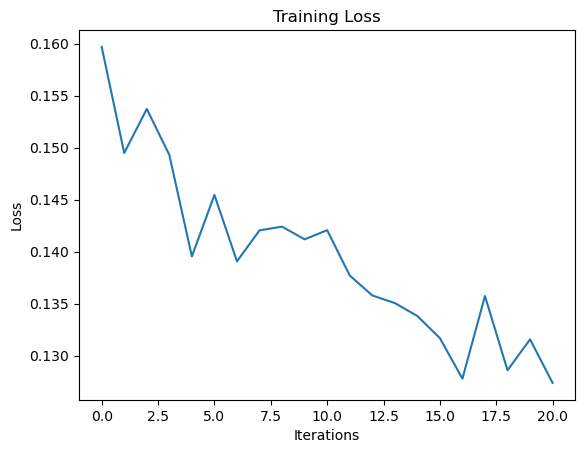

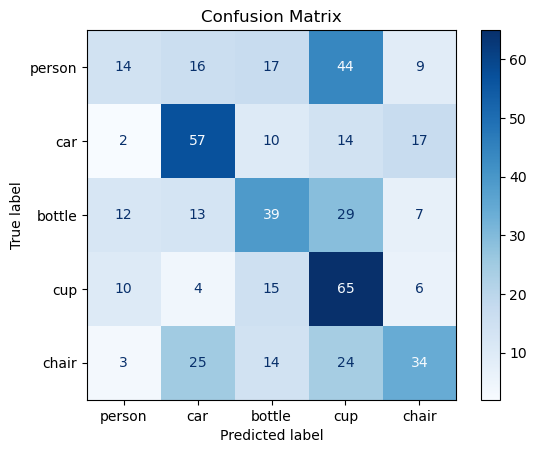

In [61]:
torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

which_dataset = "single_instance"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



true_labels, predicted_labels, missclassified = train_model(HWNet1, train_loader, val_loader)

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


true_labels, predicted_labels, missclassified = train_model(HWNet2, train_loader, val_loader)

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Observation

|           | HW4Net | HWNet1  | HWNet2 |
|----------------------|--------|------|--------|
| Training Loss| 0.12      | 0.118    | 0.126     | 
| Validation Accuracy| 42%      | 44.8%    | 41.8%      | 

HWNet1 is a 5-layer convolutional neural network with some linear layers at the end, while HWNet2 is a 10-layer convolutional neural network with some linear layers at the end. While training HWNet1 and HWNet2, I observed that the training loss is significantly smaller, but comes with a lower validation accuracy. So, I added some dropout layers to mitigate this phenomenon. HWNet1 and HWNet2 have similar performance to the 2-layer CNN HW4Net. However, by observing the training loss plot, HW4Net has a flat curve at the end, while HWNet1 and HWNet2 are still decreasing. So, if we had more epochs, I think the performance could also improve.

# Source Code

In [ ]:
raise Exception("This is souce code(prevent running when I do rull all)")


# this code is borrow from HW4_spring2025.pdf, my code will be follow by a comment
from PIL import Image
import os
from pycocotools.coco import COCO

# Set COCO dataset paths
data_dir = os.getcwd()
ann_file = os.path.join(data_dir, "annotations/instances_train2014.json") 
image_dir = os.path.join(data_dir, "train2014/train2014")  
output_dir = "output_datasets"

# Load COCO dataset
coco = COCO(ann_file)

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def save_image(img_info, category_name, dataset_type, split):
    """Saves the extracted image into a structured output directory for training/validation."""
    img_path = os.path.join(image_dir, img_info['file_name'])
    save_dir = os.path.join(output_dir, dataset_type, split, category_name)
    os.makedirs(save_dir, exist_ok=True)

    # Load and resize image
    img = Image.open(img_path).resize((64, 64))
    img.save(os.path.join(save_dir, img_info['file_name']))

def extract_images(cat_names, min_instances=1, max_instances=1, multiple_categories=False, dataset_type="single_instance"):
    """
    Extracts images based on object count conditions for single-instance or multi-instance datasets.
    - min_instances: Minimum number of object instances required.
    - max_instances: Maximum number of object instances allowed.
    - multiple_categories: If True, selects images with multiple different object types.
    """
    cat_ids = coco.getCatIds(catNms=cat_names)
    img_ids = coco.getImgIds(catIds=cat_ids)
    # Counter for extracted images
    extracted = 0  

    
    images_to_process = [] # List to store valid images
    target_classes = ["person", "car", "bottle", "cup", "chair"] # remeber classes we are interested in, with single categories, we need to make sure that other categories are not present
    current_category = cat_names[0] ## e.g. current_category: person
    other_categories = [cat for cat in target_classes if cat != current_category] ## e.g. other_categories: ['book', 'bottle', 'cup', 'chair']


    # loop through the images
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        # These are annotation IDs for objects detected in a specific image. (we are not using this)
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        # anns includes bounding box, category ID, and segmentation, area, imageID.
        anns = coco.loadAnns(ann_ids)


        # Count objects per category
        obj_counts = {}

        obj_categories = set() # set to store object categories in the image. e.g. {'person', 'chair'}
        
        # max_area_category = None # variable to store the category with the maximum area
        # max_area = 0

        for ann in anns:
            # return object category name, like obj_category: umbrella, obj_category: carrot...
            obj_category = coco.loadCats(ann['category_id'])[0]['name']

            # obj count for each category, like obj_counts: {'umbrella': 1}, obj_counts: {'carrot': 3}...
            obj_counts[obj_category] = obj_counts.get(obj_category, 0) + 1
            
            obj_categories.add(obj_category) # keep track of all object categories in the image

        #     if ann['area'] > max_area: # Track category with largest area
        #         max_area = ann['area']
        #         max_area_category = obj_category

        # if max_area_category != current_category: # Skip images with largest area not being the target category
        #     continue
        
        if dataset_type in ["single_instance", "multi_instance_same"]: # Skip images with other unwanted categories for single-instance and multi-instance same"
            if any(other_cat in obj_categories for other_cat in other_categories):
                continue

        if multiple_categories:
            # Ensure multiple object categories are present(modified)
            if len(obj_counts) >= 2 and current_category in obj_counts and any(other_cat in obj_counts for other_cat in other_categories): # modified this line to include other_categories
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        elif dataset_type == "multi_instance_same":
            # Ensure multiple instances of the same object category
            if cat_names[0] in obj_counts and obj_counts[cat_names[0]] >= min_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        else:
            # Ensure the number of instances falls within the desired range for single-instance
            if all(obj in obj_counts for obj in cat_names) and min_instances <= obj_counts[cat_names[0]] <= max_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1

        # Limit to 500 images per dataset for testing 
        if extracted >= 500:  
            break
        
    train_images = images_to_process[:400] # Split the images into training and validation sets (400 training, 100 validation)
    val_images = images_to_process[400:500] # Split the images into training and validation sets (400 training, 100 validation)

    for img_info in train_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'train')

    for img_info in val_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'val')


# Extract Single-instance Dataset
extract_images(["person"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["person"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["person"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

# Extract Single-instance Dataset
extract_images(["chair"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["chair"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["chair"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")


# Extract Single-instance Dataset
extract_images(["cup"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["cup"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["cup"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

# Extract Single-instance Dataset
extract_images(["bottle"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["bottle"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["bottle"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

# Extract Single-instance Dataset
extract_images(["car"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["car"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["car"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

def count_images_in_directory(directory):
    image_extensions = {'.jpg', '.jpeg', '.png'}
    total_images = 0

    for root, _, files in os.walk(directory):
        image_count = sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)
        if image_count > 0:
            print(f"{root}: {image_count} images")
        total_images += image_count

    print(f"\nTotal images: {total_images}")

count_images_in_directory("output_datasets")

import matplotlib.pyplot as plt
import random

def visualize_dataset(dataset_type, classes, output_dir="output_datasets"):
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))  # 5 rows x 3 columns grid
    fig.suptitle(f"Visualization of {dataset_type} dataset", fontsize=16)
    
    image_paths = []
    
    for category in classes:
        category_path = os.path.join(output_dir, dataset_type, 'train', category)
        if os.path.exists(category_path) and os.listdir(category_path):
            category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)] 
            random.shuffle(category_images)
            image_paths.extend(category_images[:3]) # Select 3 images per class
    
    image_paths = image_paths[:15]  # Ensure only 15 images for the grid
    
    for ax, img_path in zip(axes.ravel(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(os.path.dirname(img_path)))  # Display category name
    
    plt.tight_layout()
    plt.show()

target_classes = ["person", "car", "bottle", "cup", "chair"]
dataset_variations = ["single_instance", "multi_instance_same", "multi_instance_different"]

for variation in dataset_variations:
    visualize_dataset(variation, target_classes)


def count_images_in_directory(directory):
    image_extensions = {'.jpg', '.jpeg', '.png'}
    total_images = 0

    for root, _, files in os.walk(directory):
        image_count = sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)
        if image_count > 0:
            print(f"{root}: {image_count} images")
        total_images += image_count

    print(f"\nTotal images: {total_images}")

count_images_in_directory("output_datasets")



import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import os
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

transform = transforms.Compose([
    transforms.ToTensor(),    
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomRotation(degrees=5),     
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
])

which_dataset = "single_instance"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Class Index Mapping: {train_dataset.class_to_idx}") ## Class Index Mapping: {'bottle': 0, 'car': 1, 'chair': 2, 'cup': 3, 'person': 4}

# this is the same as pdf, but in sequential. Input size is 64x64x3, output size is 5
HW4Net = nn.Sequential(
    nn.Conv2d(3, 16, 3), # default stride is 1, padding is 0. Formula: ((W - K + 2P)/S) + 1, ((64 - 3 + 0)/1) + 1 = 62. Output: (16, 62, 62)
    nn.ReLU(), 
    nn.MaxPool2d(2, 2), # Formula:  ((H - K) / S) + 1. Halves both dimensions since kernel=2 and stride=2. 
                        # Output: (16, 31, 31)

    nn.Conv2d(16, 32, 3), # Formula: ((W - K + 2P)/S) + 1, ((31 - 3 + 0)/1) + 1 = 29. Output: (32, 29, 29)
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Halves both dimensions since kernel=2 and stride=2. Output: (32, 14, 14)

    nn.Flatten(), # 32*14*14 = 6272. Output: (6272,)
    nn.Linear(6272, 64), # Output: (64,)
    nn.ReLU(),
    nn.Linear(64, 5) # 5 output classes
)

# Create a dummy input tensor
x = torch.randn(1, 3, 64, 64)  # Batch size = 1, 3 channels, 64x64 image

for layer in HW4Net:
    x = layer(x)
    print(f"{layer.__class__.__name__}: {x.shape}")

def train_model(model, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    model = model.to(device) # change model here 

    # these code is borrowed from pdf, the one I created will be followed by a comment
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
    epochs = 7

    track_loss = []
    for epoch in range(epochs):
        model.train()  # Switch to training mode
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # reset the gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i+1) % 10 == 0:
                print("[epoch: %d, batch: %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 100))
                track_loss.append(running_loss / 100)
                running_loss = 0.0

        # Validation
        model.eval()  # Switch to evaluation mode
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        missclassified = []

        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1) # get the class index with the highest probability. output.data is the output tensor, 1 is the dimension to reduce
                correct += (predicted == labels).sum().item()# sum up the number of correct predictions. .item() is used to get the value of the tensor
                total += labels.size(0)
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                # add misclassified image into the list
                for j in range(len(labels)):
                    if predicted[j] != labels[j]:  # If the prediction is wrong
                        missclassified.append((images[j].cpu(), labels[j].cpu().item(), predicted[j].cpu().item()))

        print(f"Accuracy of validation: {100 * correct / total}%")


    plt.plot(track_loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


    return true_labels, predicted_labels, missclassified

true_labels, predicted_labels, missclassified = train_model(HW4Net, train_loader, val_loader)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

which_dataset = "multi_instance_same"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


true_labels, predicted_labels, missclassified = train_model(HW4Net, train_loader, val_loader)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

which_dataset = "multi_instance_different"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


true_labels, predicted_labels, missclassified = train_model(HW4Net, train_loader, val_loader)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


import random
def plot_misclassified(misclassified, class_names):
  
    random.shuffle(misclassified)

    num_images = 25

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()  # Flatten axes array to easily iterate over

    for i in range(num_images):
        img, true_label, pred_label = misclassified[i]
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

        # Denormalize if using normalization in transform
        img = (img * 0.5) + 0.5  

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        axes[i].axis("off")
    plt.show()

# Plot misclassified images
random.shuffle(missclassified)
missclassified = missclassified[:25]

plot_misclassified(missclassified, class_names=train_dataset.classes)


HWNet1 = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(3, 32, 3, padding=1), # Formula: ((W - K + 2P)/S) + 1. ((64 - 3 + 2)/1) + 1 = 64. Output: (32, 64, 64)
    nn.BatchNorm2d(32), 
    nn.ReLU(),
    # Second convolutional layer
    nn.Conv2d(32, 32, 3, padding=1), # Output: (32, 64, 64)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Formula:  ((H - K) / S) + 1. Halves both dimensions since kernel=2 and stride=2. Output: (32, 32, 32)
    nn.Dropout2d(0.05), 

    # Third convolutional layer
    nn.Conv2d(32, 64, 3, padding=1), # (32  -3 + 1)/1 + 1 = 32. Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    # Fourth convolutional layer
    nn.Conv2d(64, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Output: (64, 16, 16)
    nn.Dropout2d(0.05),

    # Fifth convolutional layer
    nn.Conv2d(64, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Output: (128, 8, 8)
    nn.Dropout2d(0.05),

    # Fully connected layers
    nn.Flatten(), # Output: (128*8*8 = 8192, )
    nn.Linear(8192, 512), # Output: (512, )
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(512, 128), # Output: (128, )
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(128, 5) # Output: 5 classes
)




HWNet2 = nn.Sequential(
    # First convolutional layer
    nn.Conv2d(3, 32, 3, padding=1), # Formula: ((W - K + 2P)/S) + 1. ((64 - 3 + 2)/1) + 1 = 64. Output: (32, 64, 64)
    nn.BatchNorm2d(32), 
    nn.ReLU(),

    # Second convolutional layer
    nn.Conv2d(32, 32, 3, padding=1), # Output: (32, 64, 64)
    nn.BatchNorm2d(32),
    nn.ReLU(),

    # Third convolutional layer
    nn.Conv2d(32, 32, 3, padding=1), # (64  -3 + 1)/1 + 1 = 32. Output: (32, 64, 64)
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # Output: (32, 32, 32) 

    # Fourth convolutional layer
    nn.Conv2d(32, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # Fifth convolutional layer
    nn.Conv2d(64, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # Sixth convolutional layer
    nn.Conv2d(64, 64, 3, padding=1), # Output: (64, 32, 32)
    nn.BatchNorm2d(64),
    nn.ReLU(), 
    nn.MaxPool2d(2, 2), # Output: (64, 16, 16)

    # Seventh convolutional layer
    nn.Conv2d(64, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Eigth convolutional layer
    nn.Conv2d(128, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Ninth convolutional layer
    nn.Conv2d(128, 128, 3, padding=1), # Output: (128, 16, 16)
    nn.BatchNorm2d(128),
    nn.ReLU(), 
    nn.MaxPool2d(2, 2), # Output: (128, 8, 8)

    # tenth convolutional layer
    nn.Conv2d(128, 128, 3, padding=1), # Output: (128, 8, 8)
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # Fully connected layers
    nn.Flatten(), # Output: (128*8*8 = 8192, )
    nn.Linear(8192, 512), # Output: (512, )
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.05),

    nn.Linear(512, 128), # Output: (128, )
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.05),

    nn.Linear(128, 5) # Output: 5 classes
)

torch.manual_seed(0)  # Set seed for reproducibility
np.random.seed(0)
random.seed(0)                # Python's built-in random module seed

# Ensure CUDA deterministic behavior
torch.cuda.manual_seed(0)

which_dataset = "single_instance"  # Choose dataset type: single_instance, multi_instance_same, multi_instance_different

# Define Loc for train and val
train_loc = os.path.join("output_datasets", which_dataset, 'train')
val_loc = os.path.join("output_datasets", which_dataset, 'val')

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_loc, transform=transform)
val_dataset = datasets.ImageFolder(root=val_loc, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



true_labels, predicted_labels, missclassified = train_model(HWNet1, train_loader, val_loader)

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


true_labels, predicted_labels, missclassified = train_model(HWNet2, train_loader, val_loader)

cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Exception: This is souce code(prevent running when I do rull all)